In [208]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['HUGGINGFACE_API_KEY'] = os.getenv('HUGGINGFACE_API_KEY')

In [262]:
from typing import Literal
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_core.output_parsers import PydanticOutputParser, StrOutputParser
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

In [263]:
model = ChatGroq(model_name="openai/gpt-oss-120b")
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Design a simple workflow without tool calling

In [264]:
def call_model(state: MessagesState):
    messages = state["messages"]
    print(f"this is my current message: {messages}")
    response = model.invoke(messages)
    return {"messages": [response]}

### this code is for testing

In [265]:
state = {"messages": ["Hi"]}
call_model(state)["messages"][0].content

this is my current message: ['Hi']


'Hello! How can I help you today?'

In [266]:
workflow = StateGraph(MessagesState)

In [267]:
workflow.add_node("mybot", call_model)


In [268]:
workflow.add_edge(START, "mybot")

In [269]:
workflow.add_edge("mybot", END)

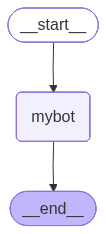

In [270]:
workflow.compile()

In [271]:
app = workflow.compile()

In [272]:
input = {"messages": ["Who is the president of the United States?"]}

In [273]:
app.invoke(input)

this is my current message: [HumanMessage(content='Who is the president of the United States?', additional_kwargs={}, response_metadata={}, id='a4ffcd23-fe11-49e1-8da6-13bf88931d23')]


{'messages': [HumanMessage(content='Who is the president of the United States?', additional_kwargs={}, response_metadata={}, id='a4ffcd23-fe11-49e1-8da6-13bf88931d23'),
  AIMessage(content='I’m sorry, but I don’t have current information about events that occurred after\u202fJune\u202f2024, so I can’t tell you who is serving as President of the United States in February\u202f2026. As of my last update, Joe\u202fBiden was the incumbent president, but I don’t have the results of the 2024 election or any subsequent developments.', additional_kwargs={'reasoning_content': 'The user asks "Who is the president of the United States?" As of the current date 2026-02-01. Need to provide the current president. My knowledge cutoff is 2024-06, but I can extrapolate. In 2024, the election will be in November 2024. As of my knowledge cutoff, the president is Joe Biden (term ends Jan 20 2025). The 2024 election hasn\'t happened in my data. As of Feb 2026, the president would be the winner of 2024 elect

# This is a workflow with tool

### Custom tool

In [274]:
@tool
def search(query: str):
    """this is my custom tool for searching a weather in a city"""
    if "delhi" in query.lower():
        return "the weather in delhi is 25 degrees celsius"
    return "i am not sure about the weather in that city"

In [275]:
search.invoke("what is the weather in bangalore?")

'i am not sure about the weather in that city'

In [276]:
search

StructuredTool(name='search', description='this is my custom tool for searching a weather in a city', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001F1018F5580>)

# binding a tool with llm

Note: use some good for agentic workflow since openai models are not good at reasoning


In [277]:
tools = [search]

In [278]:
llm_with_tools = model.bind_tools(tools)

In [279]:
response = llm_with_tools.invoke("what is the weather in delhi?")

In [280]:
response.content

''

In [281]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'Delhi weather'},
  'id': 'fc_9ad93d20-451f-47f5-b4fb-999a69a19e82',
  'type': 'tool_call'}]

In [282]:
def call_model(state: MessagesState):
    question = state["messages"]
    response = llm_with_tools.invoke(question) 
    return {"messages": [response]}


In [283]:
def router(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [284]:
tool_node = ToolNode(tools)

In [285]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'runtime': ('N/A', <class 'inspect._empty'>)}, _tools_by_name={'search': StructuredTool(name='search', description='this is my custom tool for searching a weather in a city', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001F1018F5580>)}, _injected_args={'search': _InjectedArgs(state={}, store=None, runtime=None)}, _handle_tool_errors=<function _default_handle_tool_errors at 0x000001F1010E0EA0>, _messages_key='messages', _wrap_tool_call=None, _awrap_tool_call=None)

In [286]:
workflow2 = StateGraph(MessagesState)

In [287]:
workflow2.add_node("llm_with_tools", call_model)

In [288]:
workflow2.add_node("mytools", tool_node)

In [289]:
workflow2.add_edge(START, "llm_with_tools")
workflow2.add_conditional_edges(
    "llm_with_tools",
    router,
    {
        "tools": "mytools",
        END : END
    }
    
)

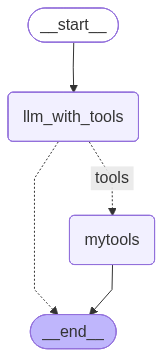

In [290]:
workflow2.compile()

In [291]:
app = workflow2.compile()

In [292]:
app.invoke({"messages": ["who is elon musk?"]})

{'messages': [HumanMessage(content='who is elon musk?', additional_kwargs={}, response_metadata={}, id='99c59fe4-e022-444a-ad4f-8fb46449277a'),
  AIMessage(content='Elon Musk is a South‑African‑born entrepreneur, engineer, and inventor who has become one of the most prominent figures in technology and business. He is best known for:\n\n| Role | Company / Project | Notable Achievements |\n|------|-------------------|----------------------|\n| **CEO & Lead Designer** | **SpaceX** (Space Exploration Technologies Corp.) | Developed the Falcon rockets, Dragon spacecraft, and the Starship system; pioneered reusable rockets and aims to enable human settlement on Mars. |\n| **CEO & Product Architect** | **Tesla, Inc.** | Popularized electric vehicles with the Model S, 3, X, and Y; expanded battery technology, autonomous driving, and energy‑storage solutions. |\n| **Founder / Co‑founder** | **Neuralink** | Working on brain‑computer interfaces to treat neurological conditions and eventually merg

In [293]:
app.invoke({"messages": ["what is weather in delhi?"]})

{'messages': [HumanMessage(content='what is weather in delhi?', additional_kwargs={}, response_metadata={}, id='0040a68e-4901-48f9-9a13-39c2d1f0ad9b'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks "what is weather in delhi?" Need to fetch weather via the provided function search. Use query likely "Delhi weather". We\'ll call function.', 'tool_calls': [{'id': 'fc_cba2b5ac-53c8-43de-954c-68d357653233', 'function': {'arguments': '{"query":"Delhi weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 132, 'total_tokens': 192, 'completion_time': 0.125029323, 'completion_tokens_details': {'reasoning_tokens': 33}, 'prompt_time': 0.006985801, 'prompt_tokens_details': None, 'queue_time': 0.074306929, 'total_time': 0.132015124}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_8a618bed98', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_

In [294]:
app.invoke({"messages": ["what is weather in Bangalore?"]})

{'messages': [HumanMessage(content='what is weather in Bangalore?', additional_kwargs={}, response_metadata={}, id='c45b1ca5-71d8-49fe-b2f4-78d0c4a03b61'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "what is weather in Bangalore?" Need to get current weather. Use the provided search function. Probably query "current weather Bangalore". Use function.', 'tool_calls': [{'id': 'fc_289672b9-3759-4dfd-a6bc-064580d62946', 'function': {'arguments': '{"query":"current weather Bangalore"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 131, 'total_tokens': 193, 'completion_time': 0.130594921, 'completion_tokens_details': {'reasoning_tokens': 34}, 'prompt_time': 0.008163517, 'prompt_tokens_details': None, 'queue_time': 0.049966443, 'total_time': 0.138758438}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e10890e4b9', 'service_tier': 'on_demand', 'finish_reason': 'tool_cal

# Mutiple tools and React Agent

In [295]:
workflow2.add_edge("mytools", "llm_with_tools")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


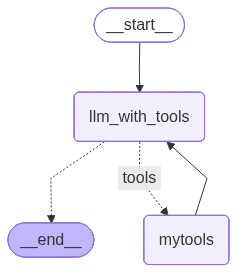

In [296]:
workflow2.compile()

In [297]:
app2 = workflow2.compile()

In [298]:
for output in app2.stream({"messages":["What is the weather in new delhi?"]}):
    for key, value in output.items():
        print(f"here is output from {key}")
        print("---------")
        print(value)
        print("\n")

here is output from llm_with_tools
---------
{'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to get weather in New Delhi. Use the provided function search with query.', 'tool_calls': [{'id': 'fc_7669e61c-6df2-4dd4-ae52-0c2b40b18f72', 'function': {'arguments': '{"query":"weather in New Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 134, 'total_tokens': 181, 'completion_time': 0.098482619, 'completion_tokens_details': {'reasoning_tokens': 18}, 'prompt_time': 0.00536887, 'prompt_tokens_details': None, 'queue_time': 0.155866799, 'total_time': 0.103851489}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_4727af4560', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1925-6de1-75c3-bc04-f0610b73bb79-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in New Delhi'}, 'id': 'fc_7669

# Memory in langGraph

In [299]:
from langgraph.checkpoint.memory import MemorySaver

In [300]:
memory = MemorySaver()

In [301]:
workflow3 = StateGraph(MessagesState)
workflow3.add_node("llm_with_tools", call_model)
workflow3.add_node("mytools",tool_node)
workflow3.add_edge(START, "llm_with_tools")
workflow3.add_conditional_edges(
    "llm_with_tools",
    router,
    {
        "tools": "mytools",
        END: END,
    },
)
workflow3.add_edge("mytools", "llm_with_tools")

In [302]:
app4 = workflow3.compile(checkpointer=memory)


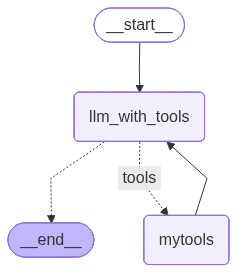

In [303]:
app4

In [304]:
config={"configurable":{"thread_id":"1"}}

In [305]:
events = app4.stream({"messages":["What is the weather in new delhi?"]}, config=config, stream_mode="values")

In [306]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the weather in new delhi?
================================== Ai Message ==================================
Tool Calls:
  search (fc_4393d52f-8a34-4211-9215-248d53d1deeb)
 Call ID: fc_4393d52f-8a34-4211-9215-248d53d1deeb
  Args:
    query: weather New Delhi
================================= Tool Message =================================
Name: search

the weather in delhi is 25 degrees celsius
================================== Ai Message ==================================

The current weather in New Delhi is about **25 °C**.


In [307]:
events = app4.stream({"messages":["What is the weather in indore?"]}, config=config, stream_mode="values")

In [308]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the weather in indore?
================================== Ai Message ==================================
Tool Calls:
  search (fc_a1d311ec-0da6-4ffb-b87e-c7729f496e3e)
 Call ID: fc_a1d311ec-0da6-4ffb-b87e-c7729f496e3e
  Args:
    query: weather Indore
================================= Tool Message =================================
Name: search

i am not sure about the weather in that city
================================== Ai Message ==================================
Tool Calls:
  search (fc_739869de-4a90-4aa8-9b17-3bab47274ab0)
 Call ID: fc_739869de-4a90-4aa8-9b17-3bab47274ab0
  Args:
    query: current temperature Indore
================================= Tool Message =================================
Name: search

i am not sure about the weather in that city
================================== Ai Message ==================================

I’m sorry—I wasn’t able to retrieve a current weather rea

In [309]:
memory.get(config)

{'v': 4,
 'ts': '2026-02-01T12:20:13.418640+00:00',
 'id': '1f0ff685-c07d-6da1-800a-e9bdef133c18',
 'channel_versions': {'__start__': '00000000000000000000000000000007.0.9211465580657925',
  'messages': '00000000000000000000000000000012.0.13549513360851684',
  'branch:to:llm_with_tools': '00000000000000000000000000000012.0.13549513360851684',
  'branch:to:mytools': '00000000000000000000000000000011.0.23981407748689731'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000006.0.25594163736867537'},
  'llm_with_tools': {'branch:to:llm_with_tools': '00000000000000000000000000000011.0.23981407748689731'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000010.0.7302390869024227'}},
 'updated_channels': ['messages'],
 'channel_values': {'messages': [HumanMessage(content='What is the weather in new delhi?', additional_kwargs={}, response_metadata={}, id='2e8b75de-d356-4c86-bdbe-25ff66d4ed76'),
   AIMessage(content='', additional_kwarg